In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import gc
import sys
%matplotlib inline


# Importing Data

In [85]:
from google.colab import drive
drive.mount('/content/drive')
#pls specify your filepath here for the import of training data
filepath = '/content/drive/My Drive/Colab Notebooks/train.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
#predefine some of the data type, for memory efficiency 
type_dict={'ncodpers':np.int32, 'ind_ahor_fin_ult1':np.uint8, 'ind_aval_fin_ult1':np.uint8, 
       'ind_cco_fin_ult1':np.uint8,'ind_cder_fin_ult1':np.uint8,
            'ind_cno_fin_ult1':np.uint8,'ind_ctju_fin_ult1':np.uint8,'ind_ctma_fin_ult1':np.uint8,
            'ind_ctop_fin_ult1':np.uint8,'ind_ctpp_fin_ult1':np.uint8,'ind_deco_fin_ult1':np.uint8,
            'ind_deme_fin_ult1':np.uint8,'ind_dela_fin_ult1':np.uint8,'ind_ecue_fin_ult1':np.uint8,
            'ind_fond_fin_ult1':np.uint8,'ind_hip_fin_ult1':np.uint8,'ind_plan_fin_ult1':np.uint8,
            'ind_pres_fin_ult1':np.uint8,'ind_reca_fin_ult1':np.uint8,'ind_tjcr_fin_ult1':np.uint8,
            'ind_valo_fin_ult1':np.uint8,'ind_viv_fin_ult1':np.uint8,
            'ind_recibo_ult1':np.uint8 }

limit_rows = 700000
df = pd.read_csv(filepath, dtype=type_dict  , nrows = limit_rows ,parse_dates=['fecha_dato', 'fecha_alta'])

df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [87]:
def rename_columns(data):
    data.rename(columns = {"fecha_dato":"time_series","ncodpers":"customer_code","ind_empleado":"employee_index",\
                       "pais_residencia":"country_residence","sexo":"gender","fecha_alta":"Date_First_Customer",\
                       "ind_nuevo":"New_Customer_ind","antiguedad":"Seniority","indrel":"primary_cust",\
                       "ult_fec_cli_1t":"last_date_primary","indrel_1mes":"customer_type","tiprel_1mes":"cust_rel_type",\
                       "indresi":"residence_index","indext":"foriegn_index","conyuemp":"spouse_index","canal_entrada":"channel_by_cust_joined",\
                       "indfall":"deceased_index","tipodom":"primary_address","cod_prov":"province_code","nomprov":"province_name",\
                       "ind_actividad_cliente":"activity_index","renta":"gross_income","segmento":"segmentation",\
                       "ind_ahor_fin_ult1":"savings_account","ind_aval_fin_ult1":"guarantees","ind_cco_fin_ult1":"current_account",\
                       "ind_cder_fin_ult1":"derivative_account","ind_cno_fin_ult1":"payroll_account","ind_ctju_fin_ult1":"jnr_account",\
                       "ind_ctma_fin_ult1":"mas_particular_account","ind_ctop_fin_ult1":"particular_account","ind_ctpp_fin_ult1":"particular_Plus_Account",\
                       "ind_deco_fin_ult1":"short_term_deposits","ind_deme_fin_ult1":"medium_term_deposits",\
                       "ind_dela_fin_ult1":"long_term_deposits","ind_ecue_fin_ult1":"e_account","ind_fond_fin_ult1":"funds",\
                       "ind_hip_fin_ult1":"mortgage","ind_plan_fin_ult1":"pensions","ind_pres_fin_ult1":"loans",\
                       "ind_reca_fin_ult1":"taxes","ind_tjcr_fin_ult1":"credit_card","ind_valo_fin_ult1":"securities",\
                       "ind_viv_fin_ult1":"home_account","ind_nomina_ult1":"payroll","ind_nom_pens_ult1":"pensions1",
                       "ind_recibo_ult1":"direct_debit"},inplace=True)

In [88]:
rename_columns(df)


output_cols = ["savings_account","guarantees","current_account","derivative_account",\
           "payroll_account","jnr_account","mas_particular_account","particular_account",\
           "particular_Plus_Account","short_term_deposits","medium_term_deposits","long_term_deposits",\
           "e_account","funds","mortgage","pensions",\
            "loans","taxes","credit_card","securities",\
            "home_account","payroll","pensions1","direct_debit"]

feature_cols = []
for col in df.columns:
  if(col not in output_cols):
    feature_cols.append(col)


train_cols = feature_cols + output_cols

train = df.filter(train_cols)

train.head()

,time_series,customer_code,employee_index,country_residence,gender,age,Date_First_Customer,New_Customer_ind,Seniority,primary_cust,last_date_primary,customer_type,cust_rel_type,residence_index,foriegn_index,spouse_index,channel_by_cust_joined,deceased_index,primary_address,province_code,province_name,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivative_account,payroll_account,jnr_account,mas_particular_account,particular_account,particular_Plus_Account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,securities,home_account,payroll,pensions1,direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


# Null Values and Correlation

In [89]:
#Function to get a sorted correlation plot, based on the target column specified ( decreasing)
def CorrPlotLargest(df, target):
    k = 10
    numerical_feature_columns = list(df._get_numeric_data().columns)
    cols = df[numerical_feature_columns].corr().nlargest(k, target)[target].index
    cm = df[cols].corr()
    plt.figure(figsize=(10,6))
    return sns.heatmap(cm, annot=True, cmap = 'viridis')

#Function to get a sorted correlation plot, based on the target column specified (increasing)
def CorrPlotSmallest(df, target):
    k = 10
    numerical_feature_columns = list(df._get_numeric_data().columns)
    cols = df[numerical_feature_columns].corr().nsmallest(k-1, target)[target].index
    cols = cols.insert(0,target)
    cm = df[cols].corr()
    plt.figure(figsize=(10,6))
    return sns.heatmap(cm, annot=True, cmap = 'viridis')

In [90]:
null_values = train.isnull().sum() * 100 / len(train)
null_values.sort_values(ascending = False)

spouse_index               99.987286
last_date_primary          99.883429
gross_income               17.712429
province_name               1.763286
province_code               1.763286
segmentation                1.124000
channel_by_cust_joined      1.120571
gender                      1.113143
cust_rel_type               1.112857
activity_index              1.112857
primary_address             1.112857
deceased_index              1.112857
employee_index              1.112857
foriegn_index               1.112857
residence_index             1.112857
customer_type               1.112857
country_residence           1.112857
primary_cust                1.112857
New_Customer_ind            1.112857
Date_First_Customer         1.112857
payroll                     0.523143
pensions1                   0.523143
age                         0.000000
Seniority                   0.000000
customer_code               0.000000
direct_debit                0.000000
savings_account             0.000000
g

In [91]:
train[['cust_rel_type','customer_type']].value_counts()

cust_rel_type  customer_type
A              1.0              367622
I              1.0              324555
P              3.0                  32
I              2.0                   1
dtype: int64

Now in the above plot we can see that 2 of the columns have 99% empty entries, so we just drop them right away and we can predict the renta based on the columns its most correlated with, and the ones we think imply some causality as well.

In [92]:
train.primary_address.unique()
#Only one unique value for the column primary_address

array([ 1., nan])

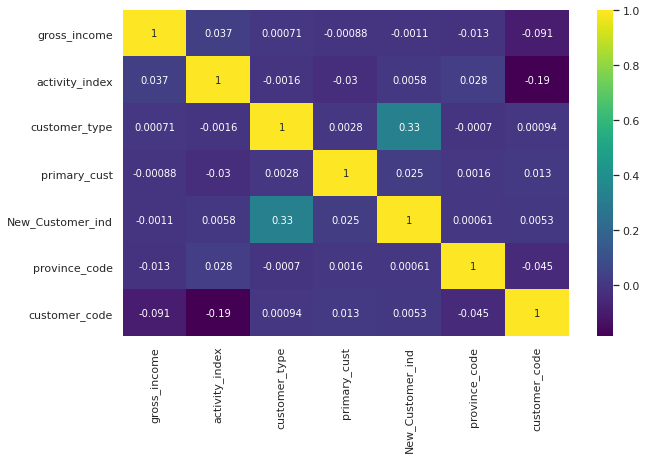

In [93]:
CorrPlotLargest(df[feature_cols],'gross_income')

In [94]:
#This function is a representation of how many times are the user entries present.
train['customer_code'].value_counts()

454194     2
544341     2
525638     2
535875     2
547328     2
          ..
1057614    1
1059663    1
1102672    1
1104721    1
1048576    1
Name: customer_code, Length: 625587, dtype: int64

In [95]:
del df

## Some initial Product Count analysis

In [97]:
output_cols = pd.read_csv(filepath, dtype='float16', 
                    usecols=['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 
                             'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1'])

From the above data we can see that most of the customers have the entries for the entirity of 16 months , we ahve a small peak on 10 months as well could be something useful

In [98]:
train.head()

,time_series,customer_code,employee_index,country_residence,gender,age,Date_First_Customer,New_Customer_ind,Seniority,primary_cust,last_date_primary,customer_type,cust_rel_type,residence_index,foriegn_index,spouse_index,channel_by_cust_joined,deceased_index,primary_address,province_code,province_name,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivative_account,payroll_account,jnr_account,mas_particular_account,particular_account,particular_Plus_Account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,securities,home_account,payroll,pensions1,direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [99]:
amount_bought = output_cols.astype('float64').sum(axis = 0)

In [100]:
amount_bought

ind_ahor_fin_ult1       1318.0
ind_aval_fin_ult1        300.0
ind_cco_fin_ult1     8383973.0
ind_cder_fin_ult1       5060.0
ind_cno_fin_ult1     1030559.0
ind_ctju_fin_ult1     121716.0
ind_ctma_fin_ult1     124645.0
ind_ctop_fin_ult1    1660027.0
ind_ctpp_fin_ult1     557737.0
ind_deco_fin_ult1      23958.0
ind_deme_fin_ult1      21647.0
ind_dela_fin_ult1     555164.0
ind_ecue_fin_ult1    1053382.0
ind_fond_fin_ult1     237597.0
ind_hip_fin_ult1       75808.0
ind_plan_fin_ult1     117800.0
ind_pres_fin_ult1      33866.0
ind_reca_fin_ult1     671445.0
ind_tjcr_fin_ult1     570964.0
ind_valo_fin_ult1     328049.0
ind_viv_fin_ult1       49552.0
ind_nomina_ult1       697652.0
ind_nom_pens_ult1     757237.0
ind_recibo_ult1      1632662.0
dtype: float64

In [101]:
plt.figure(figsize = (8,4))
amount_bought.values


array([1.318000e+03, 3.000000e+02, 8.383973e+06, 5.060000e+03,
       1.030559e+06, 1.217160e+05, 1.246450e+05, 1.660027e+06,
       5.577370e+05, 2.395800e+04, 2.164700e+04, 5.551640e+05,
       1.053382e+06, 2.375970e+05, 7.580800e+04, 1.178000e+05,
       3.386600e+04, 6.714450e+05, 5.709640e+05, 3.280490e+05,
       4.955200e+04, 6.976520e+05, 7.572370e+05, 1.632662e+06])

<Figure size 576x288 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

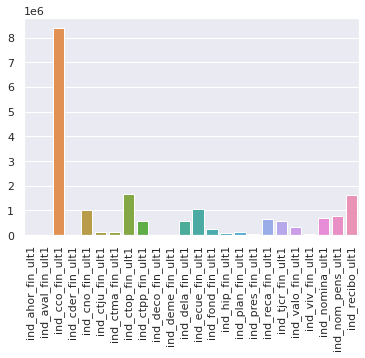

In [102]:
sns.barplot(amount_bought.index,amount_bought.values)
plt.xticks(rotation='vertical')

Looking at this we can see that the  most bought item from the banks are the corrent accounts (ind_cco_fin_ult1) and the least bought is Guarentees (ind_aval_fin_ult1)

# Date of Joining and Date of recording of data EDA

In [103]:
train = pd.read_csv(filepath,usecols=['fecha_dato','fecha_alta'],parse_dates=['fecha_dato','fecha_alta'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


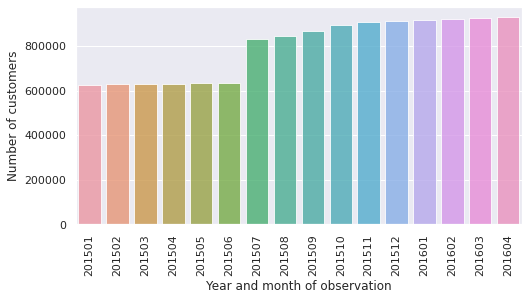

In [104]:
#Creating a new column for the year + month of observation each employee_index
train['fecha_dato_yearmonth'] = train['fecha_dato'].apply(lambda x: (100*x.year) + x.month)
yearmonth = train['fecha_dato_yearmonth'].value_counts()

#A plot of the number of employee index per time_series datapoint
plt.figure(figsize=(8,4))
sns.barplot(yearmonth.index, yearmonth.values, alpha=0.8)
plt.xlabel('Year and month of observation', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So we can see here that the distrubtion was quite similar during the first half of the year but after the 6th month there was a significant increase in the amount of customers, which then ever slightly increased till the next year as well. Maybe some scheme launched by us, or some specific reason other than seasonal caused this as the effects were permanent even through till the next year.

In [ ]:
#Creating a new column for the year + month of joining each employee_index
train['fecha_alta_yearmonth'] = train['fecha_alta'].apply(lambda x: (100*x.year) + x.month)
yearmonth = train['fecha_alta_yearmonth'].value_counts()
plt.figure(figsize=(15,4))

#A plot of the number of employee index per data joining grouped over datapoints
sns.barplot(yearmonth.index, yearmonth.values, alpha=0.8)
plt.xlabel('Year and month of joining', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
#A closer look at the above plot at the end of the years
year_month = yearmonth.sort_index().reset_index()
year_month = year_month.iloc[185:]
year_month.columns = ['yearmonth', 'number_of_customers']

plt.figure(figsize=(12,4))
sns.barplot(year_month.yearmonth.astype('int'), year_month.number_of_customers, alpha=0.8)
plt.xlabel('Year and month of joining', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So it seems that the account contracts for the customers have been there from since 1995 and there seems to be an increase in the start date of account contracts in the later stages with a  more seasonal peak (from july to december).

In [ ]:
del train

# Age EDA

In [ ]:
train = pd.read_csv(filepath, usecols=['age'])
train.head()

In [ ]:
train.age.unique()

In [ ]:
train[train.age == " NA"] = np.nan
train['age'] = train['age'].astype('float64')

In [ ]:
# A plot for the number of customer per age category (outliers detected in this)
age_series = train.age.value_counts()
age_series = age_series.sort_index()
plt.figure(figsize=(20,4))
sns.barplot(age_series.index, age_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


So most of our cutomers are between the age 20-24 and then there is some middle aged peole as well, so we can maybe remove the age gp below 20 and > 90 as it is only becoming a long tail. Also for the NaN values, we can use mean imputation technique (not a very good or preffered technique though) , to increase the dataset size.

Mean imputation refers to replacing the null values with the mean value to make it more biased towards the higher values in the dataset

In [ ]:
train.age.isnull().sum()

In [ ]:
train.age.mean()

In [ ]:
del train

# Seniority EDA

In [ ]:
#Customer seniority in months - understood as for how many months has he/she been there customers
train = pd.read_csv(filepath, usecols=['antiguedad'])
train.head()

In [ ]:
train.antiguedad.unique()

In [ ]:
#Preprocessing for antiguedad
train['antiguedad'] = train['antiguedad'].replace(to_replace=['     NA'], value=np.nan)
train[train['antiguedad'] == -999999.0]['antiguedad'] == 0
train['antiguedad'] = train['antiguedad'].astype('float64')


In [ ]:
#A plot of number of customers vs antiguedad(or seniority)
col_series = train.antiguedad.value_counts()
col_series = col_series.sort_index()
plt.figure(figsize=(20,4))
sns.barplot(col_series.index, col_series.values, alpha=0.8 )
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Customer Seniority', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# Gross Income EDA

In [ ]:
#renta = gross dometic income
train = pd.read_csv(filepath, usecols=['renta'])
train.head()

In [ ]:
unique_values = np.sort(train.renta.unique())
plt.scatter(range(len(unique_values)), unique_values)
plt.show()

This data doesnt seem right seems very skewed might be due to some very weatlhy outliers lets see

In [ ]:
train.renta.mean()

In [ ]:
train.renta.median()

In [ ]:
train.renta.isnull().sum()

In [ ]:
#Seeing how the log transformation affects it
fig, ax = plt.subplots(figsize=(30,15))
sample_df = pd.DataFrame()
sample_df['renta'] = train['renta']
sample_df['renta'] = np.log(sample_df['renta'])
train['renta'].hist(color='plum', edgecolor='black',  
                          grid=False, bins= 100)
ax.set_title('Gross Income bins', fontsize=12)
ax.set_xlabel('Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
fig, ax = plt.subplots(figsize=(30,15))
sample_df['renta'].hist(color='plum', edgecolor='black',  
                          grid=False, bins= 100)
ax.set_title('Gross Income bins', fontsize=12)
ax.set_xlabel('Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
#Plotting quartile range vs gross income to see presence of outliers
train.fillna(101850., inplace=True) #filling NA as median for now
quantile_series = train.renta.quantile(np.arange(0.99,1,0.001))
plt.figure(figsize=(12,4))
sns.barplot((quantile_series.index*100), quantile_series.values, alpha=0.8)
plt.ylabel('Rent value', fontsize=12)
plt.xlabel('Quantile value', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So you can see that there is a huge gap between the 99.9 percentile of rent amount and 100 percentile

In [ ]:
del train

# Product Analysis

In [ ]:
#predefine some of the data type, for memory efficiency 
type_dict={'ncodpers':np.int32, 'ind_ahor_fin_ult1':np.uint8, 'ind_aval_fin_ult1':np.uint8, 
       'ind_cco_fin_ult1':np.uint8,'ind_cder_fin_ult1':np.uint8,
            'ind_cno_fin_ult1':np.uint8,'ind_ctju_fin_ult1':np.uint8,'ind_ctma_fin_ult1':np.uint8,
            'ind_ctop_fin_ult1':np.uint8,'ind_ctpp_fin_ult1':np.uint8,'ind_deco_fin_ult1':np.uint8,
            'ind_deme_fin_ult1':np.uint8,'ind_dela_fin_ult1':np.uint8,'ind_ecue_fin_ult1':np.uint8,
            'ind_fond_fin_ult1':np.uint8,'ind_hip_fin_ult1':np.uint8,'ind_plan_fin_ult1':np.uint8,
            'ind_pres_fin_ult1':np.uint8,'ind_reca_fin_ult1':np.uint8,'ind_tjcr_fin_ult1':np.uint8,
            'ind_valo_fin_ult1':np.uint8,'ind_viv_fin_ult1':np.uint8,
            'ind_recibo_ult1':np.uint8 }

limit_rows = 700000
df = pd.read_csv(filepath, dtype=type_dict  , nrows = limit_rows ,parse_dates=['fecha_dato', 'fecha_alta'])

df.head()

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv', nrows=100000)
target_cols = ['ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1']
train[target_cols] = (train[target_cols].fillna(0))
train["age"] = train['age'].map(str.strip).replace(['NA'], value=0).astype('float')
train["antiguedad"] = train["antiguedad"].map(str.strip)
train["antiguedad"] = train['antiguedad'].replace(['NA'], value=0).astype('float')

train[train["antiguedad"]>65] = 65 # there is one very high skewing the graph
train[train["renta"]>1e6] = 1e6 # capping the higher values for better visualisation
train.fillna(-1, inplace=True)

In [ ]:
df['age']=pd.to_numeric(df.age, errors='coerce')

df.rename(columns = {"fecha_dato":"time_series","ncodpers":"customer_code","ind_empleado":"employee_index",\
                       "pais_residencia":"country_residence","sexo":"gender","fecha_alta":"Date_First_Customer",\
                       "ind_nuevo":"New_Customer_ind","antiguedad":"Seniority","indrel":"primary_cust",\
                       "ult_fec_cli_1t":"last_date_primary","indrel_1mes":"customer_type","tiprel_1mes":"cust_rel_type",\
                       "indresi":"residence_index","indext":"foriegn_index","conyuemp":"spouse_index","canal_entrada":"channel_by_cust_joined",\
                       "indfall":"deceased_index","tipodom":"primary_address","cod_prov":"province_code","nomprov":"province_name",\
                       "ind_actividad_cliente":"activity_index","renta":"gross_income","segmento":"segmentation",\
                       "ind_ahor_fin_ult1":"savings_account","ind_aval_fin_ult1":"guarantees","ind_cco_fin_ult1":"current_account",\
                       "ind_cder_fin_ult1":"derivative_account","ind_cno_fin_ult1":"payroll_account","ind_ctju_fin_ult1":"jnr_account",\
                       "ind_ctma_fin_ult1":"mas_particular_account","ind_ctop_fin_ult1":"particular_account",\
                       "ind_deco_fin_ult1":"short_term_deposits","ind_deme_fin_ult1":"medium_term_deposits",\
                       "ind_dela_fin_ult1":"long_term_deposits","ind_ecue_fin_ult":"e_account1","ind_fond_fin_ult1":"funds",\
                       "ind_hip_fin_ult1":"mortgage","ind_plan_fin_ult1":"pensions1","ind_pres_fin_ult1":"loans",\
                       "ind_reca_fin_ult1":"taxes","ind_tjcr_fin_ult1":"credit_card","ind_valo_fin_ult1":"securities",\
                       "ind_viv_fin_ult1":"home_account","ind_nomina_ult1":"payroll","ind_nom_pens_ult1":"pensions2",
                       "ind_recibo_ult1":"direct_debit","ind_ecue_fin_ult1":"e_account2"},inplace=True)



output_cols = ["savings_account","guarantees","current_account","derivative_account",\
           "payroll_account","jnr_account","mas_particular_account","particular_account",\
           "short_term_deposits","medium_term_deposits","long_term_deposits",\
           "long_term_deposits","e_account1","funds","mortgage","pensions1",\
           "loans","taxes","credit_card","securities","home_account","payroll","pensions2",\
           "direct_debit","e_account2"]

feature_cols = []
for col in df.columns:
  if(col not in output_cols):
    feature_cols.append(col)

In [ ]:
#A plot of the different age groups over different products
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,20))
plt.subplots_adjust(wspace=1.3, hspace=0.6)
fig_row=0
for col_id in range(24, 48):
    ax_id=col_id-24
    fig_label=df.columns[col_id]
    feat=df.columns[col_id]
    fig_col=(col_id+1)%5
    print(df[feat].value_counts())
    box_plot=sns.violinplot(y='age', data=df[(df[feat] == 1) & (df['age'] > 0) & (df['age'] < 100)], ax=axes[fig_row][fig_col],split=True, hue= 'gender')
    box_plot.set(xlabel=fig_label)
    if fig_col==4: 
      fig_row+=1

In [ ]:
data = df[(df[feat] == 1) & (df['age'] > 0) & (df['age'] < 100)]

In [ ]:
#A plot of how products are bought over different provinces vary
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(9,18))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
fig_row=0
for col_id in range(24, 48):
    ax_id=col_id-24
    fig_label= df.columns[col_id]
    feat=df.columns[col_id]
    fig_col=col_id%3
    sns.distplot(df.province_code[(df[feat]==1) & (df['province_code']>=0)], kde=False, 
                 axlabel=fig_label, ax=axes[fig_row][fig_col])
    if fig_col==2: 
      fig_row+=1

In [ ]:
train_cols = feature_cols + output_cols

train = df.filter(train_cols)

train.head()

In [ ]:
dummy_train = train[train['gender'].notna()]
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
dummy_train['gender'] = lb_make.fit_transform(dummy_train['gender'])
dummy_train['gender']
# H 2 
# V 3
dummy_train.customer_code.value_counts()

In [ ]:
#A plot of how products bought by different genders vary

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(9,18))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
fig_row=0

for col_id in range(24, 48):
    ax_id=col_id-24
    fig_label= df.columns[col_id]
    feat=df.columns[col_id]
    fig_col=col_id%3
    sns.distplot(dummy_train.gender[(df[feat]==1)], kde=False, 
                 axlabel=fig_label, ax=axes[fig_row][fig_col])
    if fig_col==2: 
      fig_row+=1

# Lag EDA Analysis

### Please see the other Lag notebook for this 

# Doing Time Series analysis

> Indented block



In [ ]:
from pandas import datetime
#predefine some of the data type, for memory efficiency 
type_dict={'ncodpers':np.int32, 'ind_ahor_fin_ult1':np.uint8, 'ind_aval_fin_ult1':np.uint8, 
       'ind_cco_fin_ult1':np.uint8,'ind_cder_fin_ult1':np.uint8,
            'ind_cno_fin_ult1':np.uint8,'ind_ctju_fin_ult1':np.uint8,'ind_ctma_fin_ult1':np.uint8,
            'ind_ctop_fin_ult1':np.uint8,'ind_ctpp_fin_ult1':np.uint8,'ind_deco_fin_ult1':np.uint8,
            'ind_deme_fin_ult1':np.uint8,'ind_dela_fin_ult1':np.uint8,'ind_ecue_fin_ult1':np.uint8,
            'ind_fond_fin_ult1':np.uint8,'ind_hip_fin_ult1':np.uint8,'ind_plan_fin_ult1':np.uint8,
            'ind_pres_fin_ult1':np.uint8,'ind_reca_fin_ult1':np.uint8,'ind_tjcr_fin_ult1':np.uint8,
            'ind_valo_fin_ult1':np.uint8,'ind_viv_fin_ult1':np.uint8,
            'ind_recibo_ult1':np.uint8 }

# def parser(x):
# 	return datetime.strptime(x, '%Y-%m-%d')
 
df = pd.read_csv(filepath, dtype=type_dict ,parse_dates=['fecha_dato', 'fecha_alta'],squeeze=True)



In [ ]:
rename_columns(df)

output_cols = ["savings_account","guarantees","current_account","derivative_account",\
           "payroll_account","jnr_account","mas_particular_account","particular_account",\
           "particular_Plus_Account","short_term_deposits","medium_term_deposits","long_term_deposits",\
           "e_account","funds","mortgage","pensions",\
            "loans","taxes","credit_card","securities",\
            "home_account","payroll","pensions1","direct_debit"]


# df.sort_values('Order Date')


In [ ]:
df[output_cols]

In [ ]:
df = df.groupby('time_series')[output_cols].sum()

In [ ]:
'''
Plots of different output cols change with time
'''

sns.set()
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(33,66))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
fig_row=0

for col in range(len(output_cols)):
  # print(output_cols)
  fig_col = col%3
  axes[fig_row][fig_col].plot(df.index,df[output_cols[col]].to_numpy())
  axes[fig_row][fig_col].set_xlabel(output_cols[col])
  axes[fig_row][fig_col].set_ylabel('Total Change in products')
  if fig_col==2: 
      fig_row+=1

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(df['home_account'], order=(3,2,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

Almost a gaussian error not bad . . .

In [ ]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

col = 'home_account'
X = df[col].values
# X

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
# test
history = [x for x in train]
predictions = list()
# history

for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()
fig_row=0
# Add the column here to indivdually check the seasonal decomposition of the specified column
col = 'payroll'

X = df[col].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
# test
history = [x for x in train]

decomposition = seasonal_decompose(history, model='multiplicative',freq = 1)
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
print('\t \t\t' + col.upper())
decomposition.plot()
pyplot.show()



You will see that all of the products didn't show any new things in Seasonal or residual part averything which is observed comes out to be a trend which is not very helpful for us

In [ ]:
#A plot of different columns via FFT we didn't complete this but we were trying different frequencies for a fft over our time series data

# Frequency and sampling rate
f = 10 # frequency
Fs = 100 # sampling rate

# Sine function
for col in output_cols:
  X = df[col].values
  size = int(len(X) * 0.80)
  train, test = X[0:size], X[size:len(X)]
  # test
  t = np.linspace(1,len(train),len(train))
  T = 1
  print(t)
  history = [x for x in train]
  # Perform Fourier transform using scipy
  from scipy import fftpack
  y_fft = fftpack.fft(history)
  # # Plot data
  # n = np.size(t)
  N = train.size
  fr = np.linspace(0,0.5 * (1/T),N)
  fr = fr * 1000
  
  below_cutoff = np.abs(y_fft) < 5.5
  y_fft[below_cutoff] = 0
  cleaner_signal = fftpack.ifft(y_fft)
  plt.plot(t,cleaner_signal)
  plt.plot(t,history)
  plt.show()
  

In [ ]:
cleaner_signal